In [48]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st 
import resource
import seaborn as sns
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

sns.set_style("ticks")

#for mem
import statsmodels.api as sm
import statsmodels.formula.api as smf

import piecewise_regression


In [53]:
#read in big df from Bryan's analysis
df = pd.read_csv('data/final_model_vl_summary.csv')

#add the resist_cat
df['resist_cat']=df['gmt80ls']>=1 #if resistant, resistcat True

#add the treatment cat as just placebo or else
df['trt_cat']=df['rx_code2']!='C' #if Placebo, trtcat = False

#add the clade info
clade_df = pd.read_csv('data/subtype_final_noptid.csv')
clade_df['pub_id']=clade_df['pubid']
df = pd.merge(df,clade_df,on='pub_id')

#full PK models for each ppt
pkmodel = pd.read_csv('data/sim-pk-withVLPD.csv')

#concentration at first positive AND estimated date of acquisition?
Cacql=[]
for pid in pkmodel['pub_id'].unique():
    tdf = pkmodel[pkmodel['pub_id']==pid]
    
    iCfp = np.argmin(np.abs(tdf['days_enrollment']-df[df['pub_id']==pid]['fp_day'].values))
    iCdet = np.argmin(np.abs(tdf['days_enrollment']-df[df['pub_id']==pid]['model_infection_day'].values))
    iCPR = np.argmin(np.abs(tdf['days_enrollment']-df[df['pub_id']==pid]['tpf_day'].values))
    Cacql.append([pid,pkmodel['centr_conc'].iloc[iCfp],
                      pkmodel['centr_conc'].iloc[iCdet],pkmodel['centr_conc'].iloc[iCPR]])
    
Cacqdf=pd.DataFrame(Cacql,columns=['pub_id','Cfp','Cdet','CPR'])
df = pd.merge(df,Cacqdf,on='pub_id',how='outer')

#add columns for easy plotting
cl=[]; ml=[]; 

for i in range(len(df)):
    tdf = df.iloc[i]
    if tdf['trt_cat']==True:
        ml.append('s')
        if tdf['resist_cat']==True:
            cl.append('coral')
        if tdf['resist_cat']==False:
            cl.append('tab:blue')
    
    if tdf['trt_cat']==False:
        ml.append('o')
        if tdf['resist_cat']==True:
            cl.append('tab:red')
        if tdf['resist_cat']==False:
            cl.append('navy')

df['color']=cl
df['marker']=ml

#calculate some additional variables
conc='Cfp'

#adjust this for model problem, PK model projects super low concentrations sometimes
corrCl=[]
for i in range(len(df)):
    Ci=df[conc].iloc[i]
    if Ci<1:
        corrCl.append(1)
    else:
        corrCl.append(Ci)
df['corr_'+conc]=corrCl 

df['lC']=np.log10(df['corr_'+conc])
df['lIC80']=np.log10(df['gmt80ls'])
df['lT80']=np.log10(df['corr_'+conc]/df['gmt80ls'])

df['T50']=df['corr_'+conc]/df['gmt50ls']
df['nu'] = 1/(1+df['T50']**-df['hill_ls'])
df['IIP'] = -np.log10(1-df['nu'])


In [54]:
#condense the columns into those I need here

df=df[['pub_id','study', 'trt_cat', 'study_region_cat', 'resist_cat', #ppt properties
       'gmt50ls', 'gmt80ls', 'hill_ls', 'subtype', #acquired variant properties
       'tpf_day', 'model_infection_day', 'fp_day', #times of interest
       'Cfp','Cdet','CPR', #PK modeled concentrations at times of interest
       'first_pos', 'upslope_r0', 'unadjusted_r0', 'final_setpt', #VL quantities of interest
       'lC','lIC80','lT80','IIP', #recalculated PKPD metrics
       'color']]

df.head()

,pub_id,study,trt_cat,study_region_cat,resist_cat,gmt50ls,gmt80ls,hill_ls,subtype,tpf_day,...,CPR,first_pos,upslope_r0,unadjusted_r0,final_setpt,lC,lIC80,lT80,IIP,color
0,703-0013,703,False,South Africa/703,True,3.472462,9.211779,1.420938,C,157,...,NaN,7.000000,3.313563,7.124110,4.597969,NaN,0.964344,NaN,NaN,tab:red
1,703-0015,703,True,Not South Africa/703,True,100.000000,100.000000,1.231811,C,257,...,1.024308,5.890289,2.295957,3.839242,4.305990,0.000000,2.000000,-2.000000,0.001491,coral
2,703-0109,703,True,South Africa/703,True,1.404906,4.461826,1.199645,A1C,467,...,21.206127,5.493228,3.084664,6.302663,4.504019,0.251989,0.649513,-0.397523,0.368111,coral
3,703-0132,703,True,South Africa/703,True,100.000000,100.000000,1.231811,C,414,...,18.028056,6.145362,3.112424,6.484001,4.494456,1.597714,2.000000,-0.402286,0.120407,coral
4,703-0157,703,True,Not South Africa/703,True,100.000000,100.000000,1.231811,C,135,...,57.783516,6.185457,3.072306,6.274869,4.490124,1.167935,2.000000,-0.832065,0.039183,coral


In [55]:
#long form names

vnames=['Predicted VRC01 concentration (µg/mL) \n at first positive', 
        'Acquired virus sensitivity, least sensitive IC80', 
        'Predicted titer acquired virus  \n at first positive, PT80', 
        'Instantaneous inhibitory potential \n at first positive (IIP)' ]


0.016491160276450055
0.03673923564204458
(-0.19729551948159899, 0.16092815013500109)
0.28885185181716616
(-0.635802741306944, 0.0002100906622615333)
0.5825513723017384


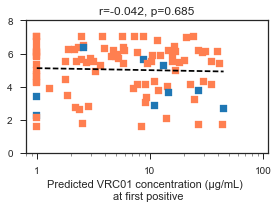

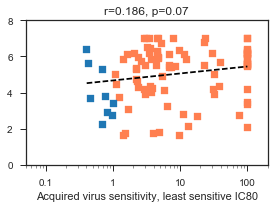

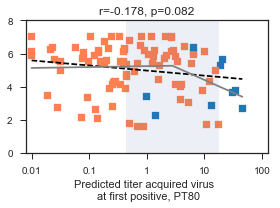

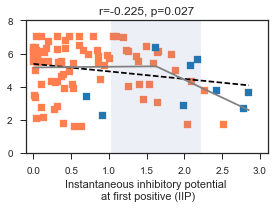

In [56]:
#first positive models for treated participants (with breakpoints)

dfT = df[df['trt_cat']==True].dropna()

y=dfT['first_pos'].values

xlimz=[[0.8,110],[0.05,200],[-2.1,2.1],[-0.1,3.1]]

pl=[]
for iv,v in enumerate(['lC', 'lIC80', 'lT80', 'IIP']):

    x=dfT[v].values
    xs=np.linspace(np.min(x),np.max(x),100)
    
    plt.figure(figsize=(4,3))
            
    #linear fit and Pearson
    m,y0=np.polyfit(x,y,1) 
    pl.append([m,y0])
    r,p=st.pearsonr(x,y)
    plt.title('r='+str(np.round(r,3))+', p='+str(np.round(p,3)))
    
    if iv<2:
        plt.scatter(10**x,y,c=dfT['color'],marker='s')#,marker=df['marker'])
        plt.semilogx(10**xs,m*xs+y0,color='k',ls='--')
    else:
        plt.scatter(x,y,c=dfT['color'],marker='s')#,marker=df['marker'])
        plt.plot(xs,m*xs+y0,color='k',ls='--')

    #piecewise
    pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
    pD=pw_fit.davies
    
    if ~np.isnan(pD):
        if pD>0.05:
            pw_fit.plot_fit(color='gray')
            pw_fit.plot_breakpoint_confidence_intervals(color='gray')
            
            #brkpt = pw_fit.get_results()['estimates']['breakpoint1']['estimate']
            brkptL = pw_fit.get_results()['estimates']['breakpoint1']['confidence_interval'][0]
            print(st.pearsonr(x[x>brkptL],y[x>brkptL]))

    plt.ylim([0,8])
    if iv<2:
        plt.xticks(np.logspace(-2,2,5),['0.01','0.1','1','10','100'])
    if iv==2:
        plt.xticks([-2,-1,0,1,2],['0.01','0.1','1','10','100'])
    plt.xlim(xlimz[iv])
    plt.xlabel(vnames[iv])
    print(pD,)
    plt.tight_layout()
    plt.savefig('figures/fpV_vs'+v+'.pdf',dpi=600)


(-0.782511427556438, 0.037538216423849295)
0.0653219524667293


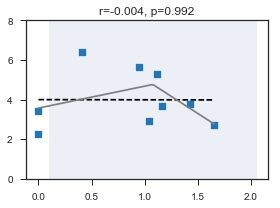

In [57]:
#concentration effect for sensitive viruses?

#first positive models for treated participants (with breakpoints)

dfT = df[(df['trt_cat']==True) & (df['resist_cat']==False)].dropna()

y=dfT['first_pos'].values

xlimz=[[0.8,110],[0.05,200],[-2.1,2.1],[-0.1,3.1]]

v='lC'

x=dfT[v].values
xs=np.linspace(np.min(x),np.max(x),100)
    
plt.figure(figsize=(4,3))

#linear fit and Pearson
m,y0=np.polyfit(x,y,1)  
r,p=st.pearsonr(x,y)
plt.title('r='+str(np.round(r,3))+', p='+str(np.round(p,3)))

plt.scatter(x,y,c=dfT['color'],marker='s')#,marker=df['marker'])
plt.plot(xs,m*xs+y0,color='k',ls='--')

#piecewise
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
pD=pw_fit.davies

if ~np.isnan(pD):
    if pD>0.05:
        pw_fit.plot_fit(color='gray')
        pw_fit.plot_breakpoint_confidence_intervals(color='gray')

        #brkpt = pw_fit.get_results()['estimates']['breakpoint1']['estimate']
        brkptL = pw_fit.get_results()['estimates']['breakpoint1']['confidence_interval'][0]
        print(st.pearsonr(x[x>brkptL],y[x>brkptL]))

plt.ylim([0,8])
#plt.xticks(np.logspace(-2,2,5),['0.01','0.1','1','10','100'])
#plt.xlim(xlimz[0])
#plt.xlabel(vnames[0])
print(pD,)
plt.tight_layout()
plt.savefig('figures/fpV_vs'+v+'_onlysens.pdf',dpi=600)


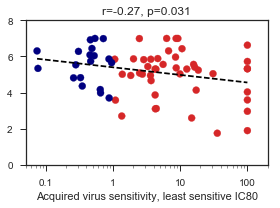

In [58]:
#look at Placebo for indirect effect

dfP = df[df['trt_cat']==False]

x=dfP['lIC80']
y=dfP['first_pos']

plt.figure(figsize=(4.,3.))

m,y0=np.polyfit(x,y,1)  
pl.append([m,y0]) #list from above
xs=np.linspace(np.min(x),np.max(x),100)

plt.scatter(10**x,y,c=dfP['color'],marker='o')#,marker=df['marker'])
plt.semilogx(10**xs,m*xs+y0,color='k',ls='--')

plt.xticks(np.logspace(-2,2,5),['0.01','0.1','1','10','100'])
plt.xlim([0.05,200])

r,p=st.pearsonr(x,y)
plt.title('r='+str(np.round(r,3))+', p='+str(np.round(p,3)))
plt.ylim([0,8])
plt.xlabel(vnames[1])
plt.tight_layout()
plt.savefig('figures/fpV_indirecteffect.pdf',dpi=600)


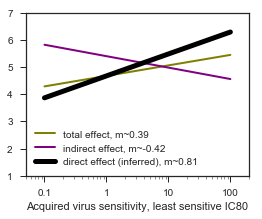

In [61]:
#now show true direct effect minus confounding

plt.figure(figsize=(4,3))
xs=np.linspace(-1,2,100)

trum = pl[1][0] - pl[4][0]
truy0 = -pl[1][1] + pl[4][1]

plt.semilogx(10**xs,xs*pl[1][0]+pl[1][1],label='total effect, m~'+str(np.round(pl[1][0],2)),lw=2,color='olive')
plt.semilogx(10**xs,xs*pl[4][0]+pl[4][1],label='indirect effect, m~'+str(np.round(pl[4][0],2)),lw=2,color='purple')
#plt.semilogx(10**xs,xs*trum+truy0,label='direct effect (inferred)')
plt.semilogx(10**xs,xs*trum+pl[1][1],label='direct effect (inferred), m~'+str(np.round(trum,2)),lw=5,color='k')
plt.ylim([1,7])
plt.xticks(np.logspace(-2,2,5),['0.01','0.1','1','10','100'])
plt.xlim([0.05,200])
plt.xlabel(vnames[1])

plt.legend()
plt.savefig('figures/fpV_inferred.pdf',dpi=600)
